In [122]:
import numpy as np
import scipy.stats as sps
from glob import glob
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from cebefo_style import Set_2D_colz_graphics
from particle import Particle

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel

from matplotlib import pyplot as plt

In [65]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

In [6]:
from uproot_methods.classes import TLorentzVector as urTLV

In [8]:
tmu = ur.open('../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates.root')['outA']['Tevts']
print tmu.keys(), '\n\n'
branches = [b for b in tmu.keys() if b[:2] == 'MC']
for b in np.sort(branches):
    print b
    
dmu = {}
for b in branches:
    dmu[b] = tmu.array(b)

['LumiBlock', 'MC_B_P', 'MC_B_eta', 'MC_B_phi', 'MC_B_pt', 'MC_D0_P', 'MC_D0_eta', 'MC_D0_phi', 'MC_D0_pt', 'MC_Dst_P', 'MC_Dst_eta', 'MC_Dst_phi', 'MC_Dst_pt', 'MC_Est_mu', 'MC_M2_miss', 'MC_mu_P', 'MC_mu_eta', 'MC_mu_phi', 'MC_mu_pt', 'MC_pis_P', 'MC_pis_eta', 'MC_pis_phi', 'MC_pis_pt', 'MC_q2', 'Run', 'eventNumber', 'n_B', 'n_D0', 'n_Dst', 'n_K', 'n_pi', 'n_pis', 'trgMu_charge', 'trgMu_eta', 'trgMu_phi', 'trgMu_pt', 'B_E', 'B_P', 'B_eta', 'B_phi', 'B_pt', 'B_pz', 'D0_E', 'D0_P', 'D0_eta', 'D0_phi', 'D0_pt', 'D0_pz', 'Dst_E', 'Dst_P', 'Dst_eta', 'Dst_phi', 'Dst_pt', 'Dst_pz', 'Est_mu', 'K_E', 'K_P', 'K_eta', 'K_phi', 'K_pt', 'K_pz', 'M2_miss', 'chi2_D0pis', 'chi2_MuDst', 'chi2_kpi', 'cos_D0pis_vtxMu', 'cos_MuDst_vtxMu', 'cos_kpi_vtxMu', 'd_vtxD0pis_vtxMu', 'd_vtxkpi_vtxMu', 'dca_D0pis_vtxMu', 'dca_kpi_vtxMu', 'mass_D0pis', 'mass_MuDst', 'mass_kpi', 'mu_E', 'mu_P', 'mu_eta', 'mu_phi', 'mu_pt', 'mu_pz', 'pi_E', 'pi_P', 'pi_eta', 'pi_phi', 'pi_pt', 'pi_pz', 'pis_E', 'pis_P', 'pis_eta', 

In [25]:
def create_urTLV(d, k, m):
    px = d[k+'_pt'] * np.cos(d[k+'_phi'])
    py = d[k+'_pt'] * np.sin(d[k+'_phi'])
    pz = d[k+'_pt'] * np.sinh(d[k+'_eta'])
    
    e = np.sqrt(m**2 + np.square(px) + np.square(py) + np.square(pz))
    return urTLV.TLorentzVectorArray(px, py, pz, e)

In [40]:
PB = create_urTLV(dmu, 'MC_B', 1e-3*Particle.from_string('B0').mass)
Pmu = create_urTLV(dmu, 'MC_mu', 1e-3*Particle.from_string('mu').mass)
PDst = create_urTLV(dmu, 'MC_Dst', 1e-3*Particle.from_string('D*-').mass)

Pv = Pmu + PDst

In [42]:
PB.p

array([ 21.528555,  43.353436,  71.411064, ...,  53.63075 ,  79.28544 ,
       103.50118 ], dtype=float32)

1.8417358393918448e-07 4.3538992e-05


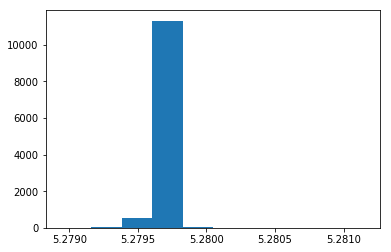

In [34]:
plt.hist(PB.mass)
print np.mean(PB.mass)-1e-3*Particle.from_string('B0').mass, np.std(PB.mass)

Now get the B momentum form different approximations

## MC truth

In [91]:
MCtruth = {}
MCtruth['B_pz'] = PB.z
MCtruth['B_p3'] = PB.p3

MCtruth['PB'] = PB

MCtruth['M2_miss'] = dmu['MC_M2_miss']
MCtruth['q2'] = dmu['MC_q2']

## Longitudinal Approx (a-la-LHCb)

In [102]:
LongApp = {}
LongApp['B_pz'] = Pv.z * 1e-3*Particle.from_string('B0').mass / Pv.mass
LongApp['B_p3'] = PB.p3 * LongApp['B_pz'] / PB.p3.z

e = np.sqrt(LongApp['B_p3'].mag2 + (1e-3*Particle.from_string('B0').mass)**2)
LongApp['PB'] = urTLV.TLorentzVectorArray(LongApp['B_p3'].x, LongApp['B_p3'].y, LongApp['B_p3'].z, e)

LongApp['M2_miss'] = (LongApp['PB'] - Pv).mass2
LongApp['q2'] = (LongApp['PB'] - PDst).mass2

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


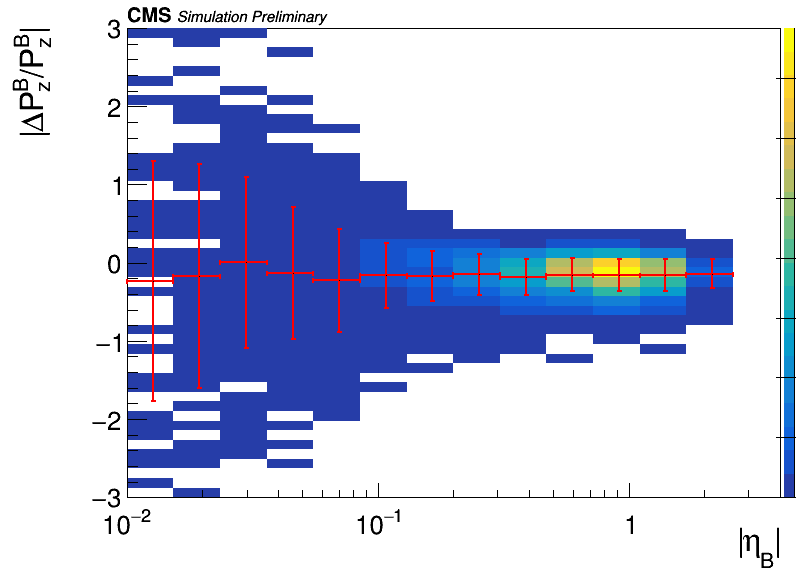

In [104]:
h = create_TH2D(
            np.column_stack((np.abs(PB.eta), (PB.z-LongApp['B_pz'])/PB.z)),
            binning = [np.logspace(-2, np.log10(4), 15), np.linspace(-3, 3, 50)],
            axis_title = ['|#eta_{B}|', '|#DeltaP_{z}^{B}/P_{z}^{B}|', '']
           )

hpfy = h.ProfileX('hpfy', 1, -1, 's')
hpfy.SetLineColor(2)
c = drawOnCMSCanvas(CMS_lumi, [h, hpfy], ['colz', 'sameE1'])
c.SetLogx()

## Transverse Approx

In [138]:
TranApp = {}
TranApp['B_pt'] = Pv.pt * 1e-3*Particle.from_string('B0').mass / Pv.mass
TranApp['B_p3'] = PB.p3 * TranApp['B_pt'] / PB.pt
TranApp['B_pz'] = TranApp['B_p3'].z

e = np.sqrt(TranApp['B_p3'].mag2 + (1e-3*Particle.from_string('B0').mass)**2)
TranApp['PB'] = urTLV.TLorentzVectorArray(TranApp['B_p3'].x, TranApp['B_p3'].y, TranApp['B_p3'].z, e)

TranApp['M2_miss'] = (TranApp['PB'] - Pv).mass2
TranApp['q2'] = (TranApp['PB'] - PDst).mass2

# Variable comparison

In [139]:
dic_list = {'MC Truth': MCtruth,
            'Long. approx': LongApp,
            'Trans. approx': TranApp
           }

In [140]:
def draw_var(vname, xtitle, binning, opt, leg_loc):
    h_l = []

    leg = rt.TLegend(leg_loc[0],leg_loc[1],leg_loc[2],leg_loc[3])
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    for n, d in dic_list.iteritems():
        h_aux = create_TH1D(
            d[vname], 
            axis_title=[xtitle, 'Events'], 
            binning=binning, opt=opt
        )
        h_aux.SetLineColor(std_color_list[len(h_l)])
        h_aux.Sumw2()
        leg.AddEntry(h_aux, n, 'l')
        h_l.append(h_aux)
    SetMaxToMaxHist(h_l)


    CMS_lumi.extraText = "     Simulation Preliminary"
    c = drawOnCMSCanvas(CMS_lumi, h_l, 'same')
    c.h_l = h_l
    c.leg = leg
    leg.Draw()
    return c

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


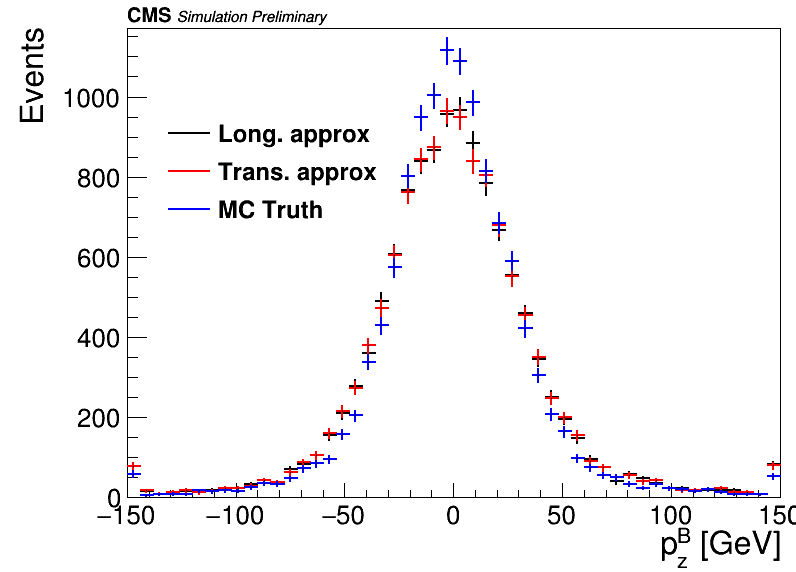

In [141]:
c = draw_var('B_pz', 'p_{z}^{B} [GeV]', binning=[50, -150, 150], opt='underflowoverflow', leg_loc=[0.2,0.6,0.5,0.8])

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


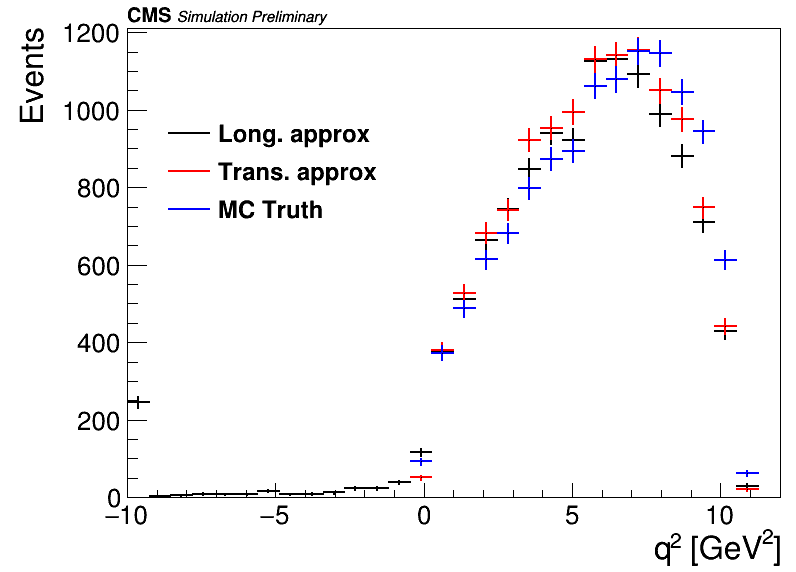

In [142]:
c = draw_var('q2', 'q^{2} [GeV^{2}]', binning=[30, -10, 12], opt='underflow', leg_loc=[0.2,0.6,0.5,0.8])

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


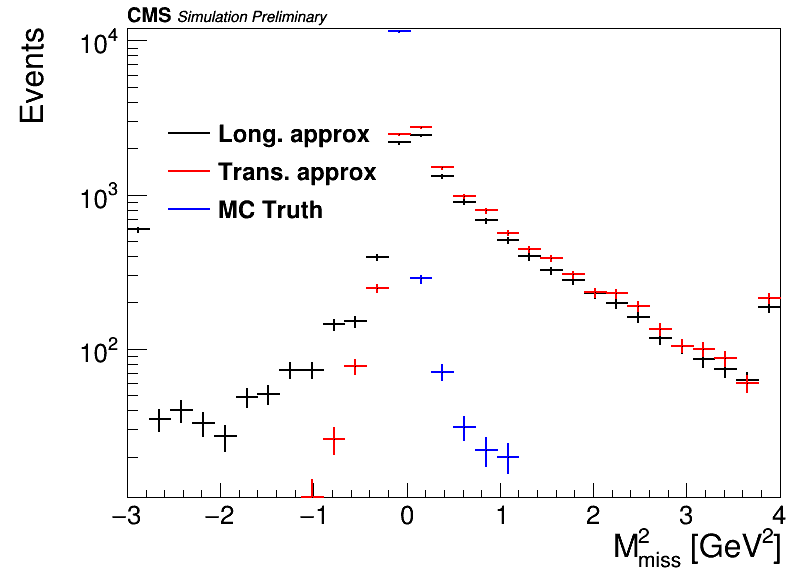

In [144]:
c = draw_var('M2_miss', 'M^{2}_{miss} [GeV^{2}]', binning=[30, -3, 4], opt='underflowoverflow', leg_loc=[0.2,0.6,0.5,0.8])
c.SetLogy()